In [1]:
# mount onto my google drive
from google.colab import drive
drive.mount('/content/drive')

# change working directory Google Drive
%cd /content/drive/My Drive/

# clone repo from github into Google Drive
!git clone https://github.com/rubingwang/socialnetwork.git

# change woring diectory into this repo
%cd /content/drive/My Drive/socialnetwork/

Mounted at /content/drive
/content/drive/My Drive
fatal: destination path 'socialnetwork' already exists and is not an empty directory.
/content/drive/My Drive/socialnetwork


In [2]:
%%capture
!pip install python-igraph
!pip install matplotlib
!pip install numpy
!pip install scipy
!pip install easygui
!pip install cairocffi

## 1.Centrality Measure 

In [3]:
# Import of required libraries and packages
import igraph as ig
import easygui
import numpy as np
import scipy
import statistics
import pandas as pd
from igraph import Graph
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from numpy import linspace
import seaborn as sns

print(ig.__version__)

0.10.4


In [4]:
# read nodes from excel 
nodes_df = pd.read_excel('flight_world.xlsx', sheet_name="Nodes")

# read edges from excel
edges_df = pd.read_excel('flight_world.xlsx', sheet_name="Edges")

# check if unpaired nodes and edges exsited 
edge_nodes = set(edges_df['Source']) | set(edges_df['Target'])
all_nodes = set(nodes_df['Id'])
missing_nodes = edge_nodes - all_nodes

# remove them if possible
for index, row in edges_df.iterrows():
    if row['Source'] in missing_nodes or row['Target'] in missing_nodes:
        edges_df.drop(index, inplace=True)

# initial igraph object
g = Graph()

# add nodes with other necessary infomation labels (here I need country==China)
for index, row in nodes_df.iterrows():
    if row['country'] == 'China':
        g.add_vertex(name=row['Id'], Label=row['Label'], Lat=row['Lat'], 
                     Lng=row['Lng'], city=row['city'], country=row['country'])

# add edges with other necessary infomation labels
for index, row in edges_df.iterrows():
    source_node = nodes_df.loc[nodes_df['Id'] == row['Source']]
    target_node = nodes_df.loc[nodes_df['Id'] == row['Target']]
    if source_node['country'].values[0] == 'China' and target_node['country'].values[0] == 'China':
        g.add_edge(row['Source'], row['Target'], weight=row['Weight'], Type=row['Type'])

# remove nodes and edges of not interest here
to_delete = [v.index for v in g.vs if v['city'] in ['Chongqing','Wuhai','Tianjin',
                                                    'Chengdu','Shanghai','Guangzhou', 
                                                    'Beijing', 'Shenzhen']]
g.delete_vertices(to_delete)
g.es.select(_source_in=to_delete).delete()
g.es.select(_target_in=to_delete).delete()

g.summary()


'IGRAPH UNW- 163 105 -- \n+ attr: Label (v), Lat (v), Lng (v), city (v), country (v), name (v), Type (e), weight (e)'

In [5]:
# define centrality measure function, since we will call it many time then
def centrality_measure(g, file):
    
    # Calculate basic centrality
    degree = g.degree()
    closeness = g.closeness()
    betweenness = g.betweenness()
    pagerank = g.pagerank()
    
    # Calculate Average Path Length
    avg_path_length = g.average_path_length()
    
    # Calculate Transitivity Undirected
    transitivity = g.transitivity_undirected()

    # Save results to DataFrames
    degree_df = pd.DataFrame({'Id': g.vs['name'], 'degree': degree})
    closeness_df = pd.DataFrame({'Id': g.vs['name'], 'closeness': closeness})
    betweenness_df = pd.DataFrame({'Id': g.vs['name'], 'betweenness': betweenness})
    pagerank_df = pd.DataFrame({'Id': g.vs['name'], 'pagerank': pagerank})
    
    # Merge DataFrames, since we need to output in a tabular 
    merged_df = pd.merge(nodes_df, degree_df, on='Id')
    merged_df = pd.merge(merged_df, closeness_df, on='Id')
    merged_df = pd.merge(merged_df, betweenness_df, on='Id')
    merged_df = pd.merge(merged_df, pagerank_df, on='Id')
    merged_df.to_excel(file+'.xlsx', index=False) #oupput excel, named by "file"

    # Sort by degree/closeness/betweenness/pagerank, and select top 10,individually 
    degree_top10 = merged_df.sort_values(by='degree', ascending=False).head(10)
    closeness_top10 = merged_df.sort_values(by='closeness', ascending=False).head(10)
    betweenness_top10 = merged_df.sort_values(by='betweenness', ascending=False).head(10)
    pagerank_top10 = merged_df.sort_values(by='pagerank', ascending=False).head(10)

    # Output top 10 results
    print("Top 10 Degree:")
    print(degree_top10[['Label', 'city', 'degree']])
    print("Top 10 Closeness:")
    print(closeness_top10[['Label',  'city', 'closeness']])
    print("Top 10 Betweenness:")
    print(betweenness_top10[['Label', 'city', 'betweenness']])
    print("Top 10 Pagerank:")
    print(pagerank_top10[['Label', 'city', 'pagerank']])
 
    # Output results
    print("Average Degree:", statistics.mean(degree))
    print("Average Betweenness:", statistics.mean(betweenness))
    print("Average Path Length:", avg_path_length)
    print("Transitivity:", transitivity)

In [6]:
# centealiry for all nodes and edges 
centrality_measure(g, "centrality_g")

Top 10 Degree:
                                      Label         city  degree
22      Hefei Luogang International Airport        Hefei      17
89     Sunan Shuofang International Airport         Wuxi      16
18     Fuzhou Changle International Airport       Fuzhou      13
1              Zhangjiakou Ningyuan Airport  Zhangjiakou      10
86  Quanzhou Jinjiang International Airport     Quanzhou       8
39                 Changzhou Benniu Airport    Changzhou       8
16       Xiamen Gaoqi International Airport       Xiamen       7
83                      Lianyungang Airport  Lianyungang       6
88                          Weifang Airport      Weifang       6
24                   Yantai Laishan Airport       Yantai       6
Top 10 Closeness:
                                       Label         city  closeness
0      Erenhot Saiwusu International Airport      Erenhot        1.0
132                  Baoshan Yunduan Airport      Baoshan        1.0
66                             Enshi Airport 

In [7]:
# define centrality distribution function
def plot_distribution(data, title):
    # Simple Histogram of degree distribution
    n, bins, patches = plt.hist(data, bins=20)

    # Add points and interpolate curve
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    plt.plot(bin_centers, n, 'ro', markersize=5)
    x = np.linspace(min(bin_centers), max(bin_centers), 1000)
    y = np.interp(x, bin_centers, n)
    plt.plot(x, y, 'b-', linewidth=2)

    # Customize plot
    metric = title.split()[0] # we extract the first word as X-label
    plt.xlabel('{}'.format(metric)) 
    plt.ylabel('Frequency')
    plt.title(title)
    plt.grid(True, color='lightgrey')

    # Show plot
    plt.show()

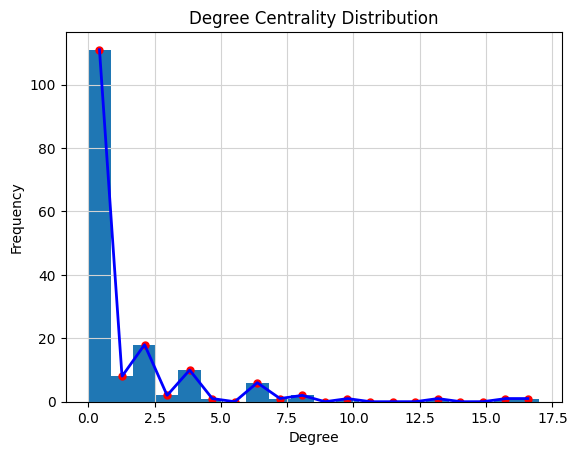

In [8]:
# degree centrality distribution 
degree = g.degree()
plot_distribution(degree, 'Degree Centrality Distribution')

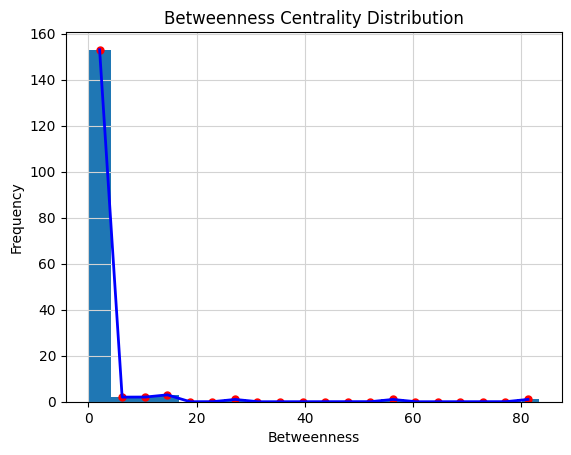

In [9]:
# betweeness centrality distribution 
betweenness = g.betweenness()
plot_distribution(betweenness, 'Betweenness Centrality Distribution')

In [10]:
# define centrality density function
def plot_density(data, title):
    # Estimation of the probability density function 
    # using a kernel-density estimation using Gaussian kernel
    kde = gaussian_kde(data, bw_method=0.1)

    # These are the values over which your kernel will be evaluated
    dist_space = linspace(min(data), max(data), 100)

    # Plot the results
    sns.set_style('whitegrid')
    fig, ax = plt.subplots()
    ax.plot(dist_space, kde(dist_space), linewidth=2, color='blue', alpha=0.8)

    # Customize the plot
    metric = title.split()[0] # we extract the first word as X-label
    ax.set_xlabel('{}'.format(metric))
    ax.set_ylabel('Probability Density')
    ax.set_title(f"{title}")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.show()


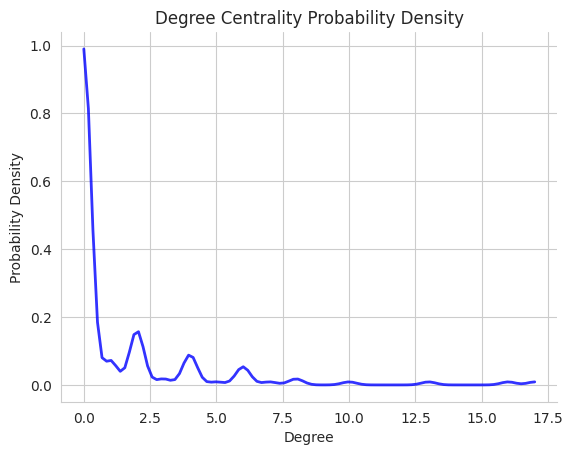

In [11]:
# degree probability density
plot_density(degree,"Degree Centrality Probability Density")

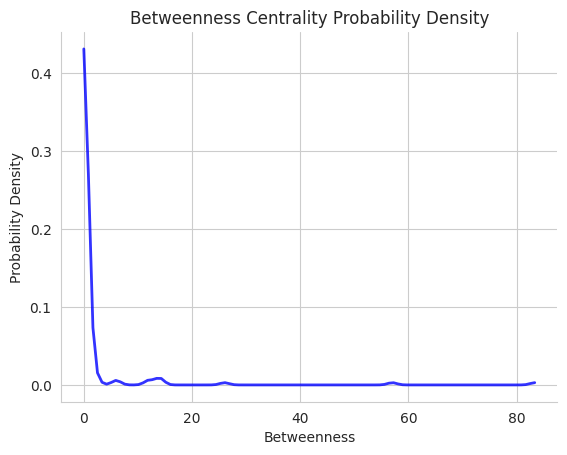

In [12]:
# betweenness probability density
plot_density(betweenness,"Betweenness Centrality Probability Density")

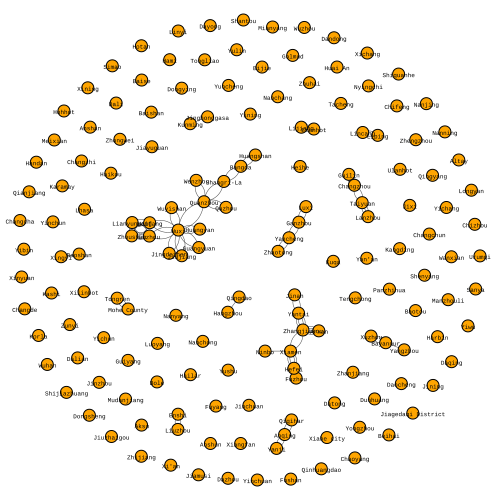

In [13]:
# Create plot using Fruchterman-Rheingold
layout_fr = g.layout("fr")

visual_style = {}
visual_style["vertex_size"] = 12
visual_style["vertex_label_size"]=6
visual_style["vertex_color"] = "orange"
visual_style["vertex_label"] = g.vs["city"]
visual_style["layout"] = layout_fr
visual_style["edge_width"]=0.5
visual_style["bbox"] = (500, 500)
visual_style["margin"] = 20

ig.plot(g, **visual_style)

In [14]:
# First, to find sturect with import nodes and edges
# Create a subgraph of nodes with a degree at least equal to the average degree
avg_degree = np.mean(g.degree())
print("Average Degree All cities:", avg_degree)
# Convert list of node degree to an np.array 
np_degree = np.array(degree)
np_degree = np.where(np_degree>=avg_degree)
print("Number of nodes with degree >= the average degree: % 2d" %(len(np_degree[0])))

#Create subgraph using IDs of nodes to be retained
important_city = g.subgraph(np_degree[0])
degree_import = important_city.degree()
print("Average Degree Important Cities:", np.mean(degree_import))

Average Degree All cities: 1.2883435582822085
Number of nodes with degree >= the average degree:  44
Average Degree Important Cities: 4.545454545454546


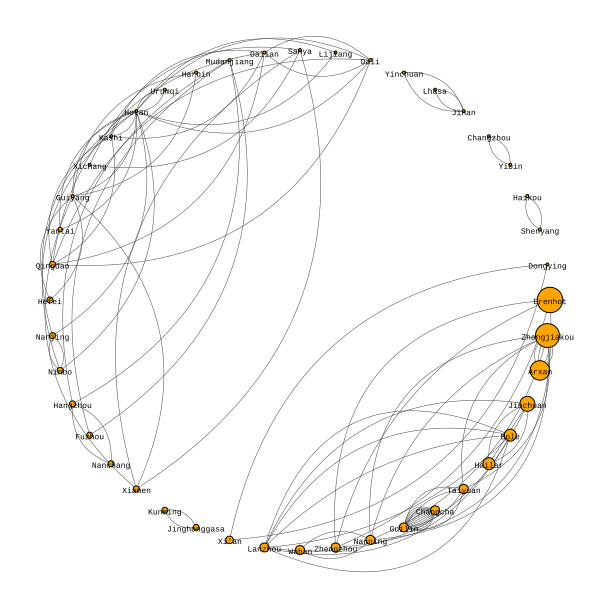

In [15]:
# Create plot for import nodes and edges using circular layout
layout_circle = important_city.layout("circle")

# Sort vertices based on degree
degree = important_city.degree()
degree_order = sorted(range(len(degree)), key=lambda k: degree[k], reverse=True)

# Define visual style
visual_style = {}
visual_style["vertex_size"] = [degree[v]*1.5 for v in degree_order]
visual_style["vertex_label_size"]=8
visual_style["vertex_color"] = "orange"
visual_style["vertex_label"] = g.vs["city"]
visual_style["layout"] = layout_circle
visual_style["edge_width"]=0.5
visual_style["bbox"] = (600, 600)
visual_style["margin"] = 50

# Plot graph
ig.plot(important_city, **visual_style)


## 2.Community Detection

In [16]:
# Identify the largest connected component
largest_g = g.components().giant()
print("Size of the largest connected component:", largest_g.vcount())

# Check if the network is connected print("Connected:", largest_g.is_connected())

Size of the largest connected component: 16


In [17]:
# Calculate modularity scores with this largest connected network
# 1) Leading_eigen Algorithom
le = largest_g.community_leading_eigenvector()
modularity_le = le.modularity
print("Modularity score using cluster_leading_eigen:", modularity_le)

# 2) louvain Algorithom
lou = largest_g.community_multilevel()
modularity_lou = lou.modularity
print("Modularity score using cluster_louvain:", modularity_lou)

# 3) cluster_walktrap Alg0rithom
wt = largest_g.community_walktrap()
wt = wt.as_clustering()
modularity_wt = wt.modularity
print("Modularity score using cluster_walktrap:", modularity_wt)

Modularity score using cluster_leading_eigen: 0.502770083102493
Modularity score using cluster_louvain: 0.502770083102493
Modularity score using cluster_walktrap: 0.4916897506925208


In [18]:

# get membership 
unique_memberships_le = set(le.membership)
unique_memberships_lou = set(lou.membership)
unique_memberships_wt = set(wt.membership)

# get number of membership
num_memberships_le = len(unique_memberships_le)
num_memberships_lou = len(unique_memberships_lou)
num_memberships_wt = len(unique_memberships_wt)

print(f"There are {num_memberships_le} unique memberships using Leading_eigen Algrithom.")
print(f"There are {num_memberships_lou} unique memberships using Louvain Algrithom.")
print(f"There are {num_memberships_wt} unique memberships using Walktrap Algrithom.")

There are 3 unique memberships using Leading_eigen Algrithom.
There are 3 unique memberships using Louvain Algrithom.
There are 4 unique memberships using Walktrap Algrithom.


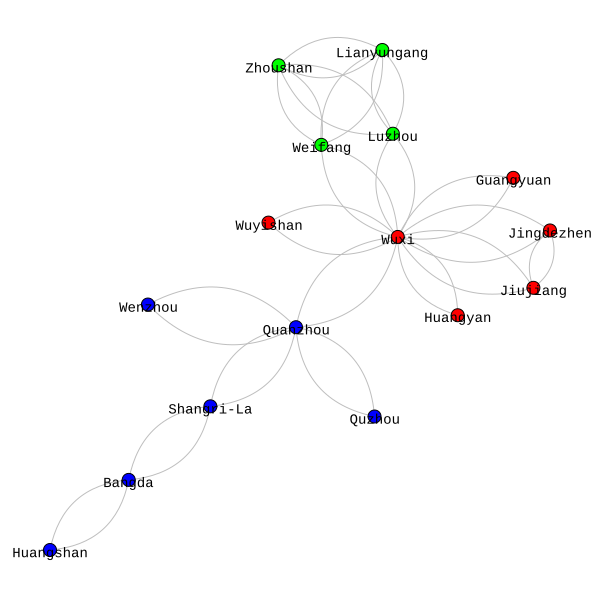

In [19]:
# 1) Plot Clustering using Leading_eigen Algrithom
# define colours for fifferent communities
color_dict = {0: "blue", 1: "green", 2: "red"} 
vertex_colors = [color_dict[membership] for membership in le.membership]
largest_g.vs["color"] = vertex_colors

# settings for figure
largest_g.vs["label"] = largest_g.vs["city"]
visual_style = {"vertex_size": 13}
visual_style["edge_width"] = 1
visual_style["edge_color"] = 'gray'
visual_style["bbox"] = (600, 600)
visual_style["margin"] = 50

ig.plot(largest_g, **visual_style)

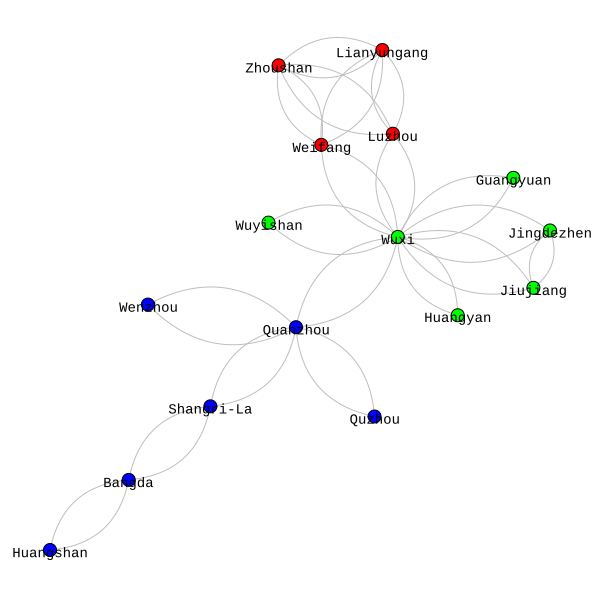

In [20]:
# 2) Plot Clustering using Louvain Algrithom
# define colours for fifferent communities
color_dict = {0: "blue", 1: "green", 2: "red"}
vertex_colors = [color_dict[membership] for membership in lou.membership]
largest_g.vs["color"] = vertex_colors

# settings for figure
largest_g.vs["label"] = largest_g.vs["city"]
visual_style = {"vertex_size": 13}
visual_style["edge_width"] = 1
visual_style["edge_color"] = 'gray'
visual_style["bbox"] = (600, 600)
visual_style["margin"] = 50


ig.plot(largest_g, **visual_style)

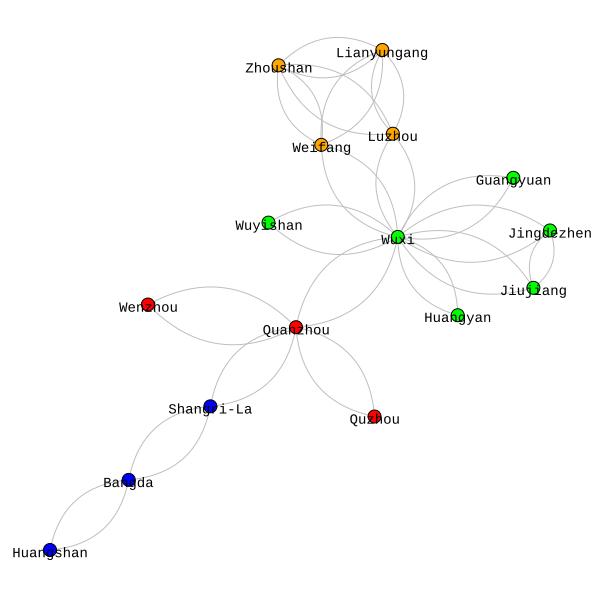

In [21]:
# 3)Plot Clustering using Walktrap Algrithom
# define colours for fifferent communities
color_dict = {0: "blue", 1: "green", 2: "red", 3:'orange'}
vertex_colors = [color_dict[membership] for membership in wt.membership]
largest_g.vs["color"] = vertex_colors

# settings for figure
largest_g.vs["label"] = largest_g.vs["city"]
visual_style = {"vertex_size": 13}
visual_style["edge_width"] = 1
visual_style["edge_color"] = 'gray'
visual_style["bbox"] = (600, 600)
visual_style["margin"] = 50

ig.plot(largest_g, **visual_style)

In [22]:
from sklearn.metrics.cluster import normalized_mutual_info_score

# Compare teh similarity using NMI score
mni_le_lou = normalized_mutual_info_score(le.membership, lou.membership)
mni_wt_le = normalized_mutual_info_score(wt.membership, le.membership)
mni_wt_lou = normalized_mutual_info_score(wt.membership, lou.membership)

print("MNI score between Leading_eigen and Louvain:", mni_le_lou)
print("MNI score between Walktrap and Louvain:", mni_wt_lou)
print("MNI score between Walktrap and Leading_eigen:", mni_wt_le)

MNI score between Leading_eigen and Louvain: 1.0000000000000002
MNI score between Walktrap and Louvain: 0.8927822818815335
MNI score between Walktrap and Leading_eigen: 0.8927822818815339


## 3.Vulnerability Analysis

In [23]:
# centrality before removing hubs
centrality_measure(largest_g,"largest_g")

Top 10 Degree:
                                      Label         city  degree
9      Sunan Shuofang International Airport         Wuxi      16
6   Quanzhou Jinjiang International Airport     Quanzhou       8
4                       Lianyungang Airport  Lianyungang       6
8                           Weifang Airport      Weifang       6
12                         Zhoushan Airport     Zhoushan       6
15                           Luzhou Airport       Luzhou       6
0                            Diqing Airport   Shangri-La       4
1                        Jingdezhen Airport   Jingdezhen       4
2                   Jiujiang Lushan Airport     Jiujiang       4
13                     Qamdo Bangda Airport       Bangda       4
Top 10 Closeness:
                                      Label        city  closeness
9      Sunan Shuofang International Airport        Wuxi   0.600000
6   Quanzhou Jinjiang International Airport    Quanzhou   0.517241
8                           Weifang Airport     Wei

In [24]:
# remove hubs
to_delete_hub = [v.index for v in largest_g.vs if v['city'] in ['Wuxi','Quanzhou']]
largest_g_without_hub = largest_g.copy()  
largest_g_without_hub.delete_vertices(to_delete_hub)

# remove related edges
largest_g_without_hub.es.select(_source_in=to_delete_hub).delete()
largest_g_without_hub.es.select(_target_in=to_delete_hub).delete()

largest_g_without_hub.summary()

'IGRAPH UNW- 14 14 -- \n+ attr: Label (v), Lat (v), Lng (v), city (v), color (v), country (v), label (v), name (v), Type (e), weight (e)'

In [25]:
# centrality after removing hubs
centrality_measure(largest_g_without_hub,"largest_g_without_hub")

Top 10 Degree:
                      Label         city  degree
4       Lianyungang Airport  Lianyungang       6
10         Zhoushan Airport     Zhoushan       6
7           Weifang Airport      Weifang       4
13           Luzhou Airport       Luzhou       4
0            Diqing Airport   Shangri-La       2
1        Jingdezhen Airport   Jingdezhen       2
2   Jiujiang Lushan Airport     Jiujiang       2
11     Qamdo Bangda Airport       Bangda       2
3            Quzhou Airport       Quzhou       0
5   Huangyan Luqiao Airport     Huangyan       0
Top 10 Closeness:
                      Label         city  closeness
0            Diqing Airport   Shangri-La       1.00
1        Jingdezhen Airport   Jingdezhen       1.00
2   Jiujiang Lushan Airport     Jiujiang       1.00
4       Lianyungang Airport  Lianyungang       1.00
10         Zhoushan Airport     Zhoushan       1.00
11     Qamdo Bangda Airport       Bangda       1.00
7           Weifang Airport      Weifang       0.75
13          

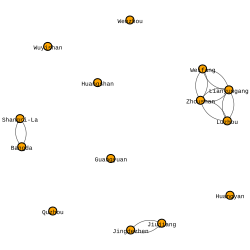

In [26]:
# Create plot using Fruchterman-Rheingold
layout_fr = largest_g_without_hub.layout("fr")

visual_style = {}
visual_style["vertex_size"] = 8
visual_style["vertex_label_size"]=6
visual_style["vertex_color"] = "orange"
visual_style["vertex_label"] = largest_g_without_hub.vs["city"]
visual_style["layout"] = layout_fr
visual_style["edge_width"]=0.5
visual_style["bbox"] = (250, 250)
visual_style["margin"] = 20

ig.plot(largest_g_without_hub, **visual_style)